### HW_lesson_2

1. Сгенерировать датасет при помощи sklearn.datasets.make_regression и обучить линейную модель при помощи градиентного и стохастического градиентного спуска. Нанести среднеквадратичную ошибку для обоих методов на один график, сделать выводы о разнице скорости сходимости каждого из методов.

2. Модифицировать решение первого задания путем добавления 𝐿2 -регуляризации (в функцию, считающую MSE, нужно добавить норму вектора весов) и сравнить результаты.

3. [опция]. Модернизировать решение задания 2, заменив L2 регуляризацию на L1 регуляризацию.

In [1]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
X, y, coef = datasets.make_regression(n_samples=5000, n_features = 2, n_informative = 2, n_targets = 1, effective_rank = None,
                                              noise = 5, coef = True, random_state = 2)

In [3]:
X.shape, y.shape, coef

((5000, 2), (5000,), array([16.8968717 , 28.29007558]))

In [4]:
X1 = np.hstack((np.ones((X.shape[0], 1)), X))

In [5]:
X1 = X1.T

In [6]:
def std_calculation(x):
        result = (x - x.mean()) / x.std()
        return result

In [7]:
def data_standartization(X):
    X_standarted = X.copy().astype(np.float64)
    for i in range(X.shape[0]):
        if i == 0:
          continue
        X_standarted[i] = std_calculation(X[i])
    return X_standarted

In [8]:
X_stand = data_standartization(X1)
X_stand

array([[ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 1.98927669,  0.8747335 , -0.48384168, ...,  0.2281815 ,
        -0.9154966 ,  1.12639576],
       [ 0.03121934,  0.34450212,  0.09830397, ...,  0.06316268,
        -0.05771426, -0.43769802]])

In [9]:
# среднее значение должно быть = 0, стандартная ошибка - 1
np.mean(X_stand[1]), np.std(X_stand[1])

(4.263256414560601e-18, 1.0)

In [10]:
def robust_scale(X):
    X_robust = X.copy().astype(np.float64)
    for i in range(X.shape[0]):
        if i == 0:
          continue
        percentiles = np.percentile(X[i], (25.0, 75.0))
        X_robust[i] = (X[i] - np.median(X[i])) / percentiles[1] - percentiles[0]
    return X_robust


In [11]:
X_rob = robust_scale(X1)
X_rob

array([[ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 3.89974865,  2.12329157, -0.04212518, ...,  1.09276006,
        -0.73013481,  2.52441304],
       [ 0.70526858,  1.18015848,  0.80695887, ...,  0.75368991,
         0.57045853, -0.00554009]])

In [12]:
def calc_mse(y, y_pred):
    error = np.mean((y - y_pred)**2)
    return error

In [13]:
def gradient_descent_alpha_div_i(X, y, start_alpha, epsilon):
    n = X.shape[1]
    W = np.random.randn(X.shape[0])
    i=1
    W_prev = np.array([])
    err_prev = 0
    err = 0
    errors = []

    while True:
        W_prev = W.copy()
        err_prev = err
        y_pred = np.dot(W, X)
        err = calc_mse(y, y_pred)
        W -= start_alpha/i * (1/n * 2 * np.dot(X, (y_pred - y)))
        errors.append(err)

        if i % 10 == 0:
            print(i, start_alpha/i, W, err)

        if np.sum(np.abs(W - W_prev)) < epsilon:
            break
  
        i+=1

    print(f"для заданной точности {epsilon}\nоптимальное количество итераций = {i-1}\nпри них получаем W = {W_prev} и mse = {err_prev}")
    return W_prev, errors

In [14]:
W, errors = gradient_descent_alpha_div_i(X_stand, y, 1, 0.00001)

10 0.1 [-0.56616349 16.9713025  28.21791704] 25.30701511502717
20 0.05 [-0.56616349 16.9718337  28.21821579] 25.30701416211835
для заданной точности 1e-05
оптимальное количество итераций = 27
при них получаем W = [-0.56616349 16.97190927 28.21825821] и mse = 25.307014130247158


Text(0, 0.5, 'MSE')

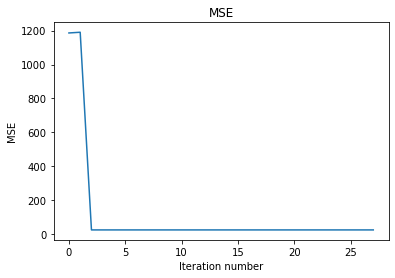

In [15]:
plt.plot(range(len(errors)), errors)
plt.title('MSE')
plt.xlabel('Iteration number')
plt.ylabel('MSE')

In [16]:

def gradient_descent(X, y, iters, alpha, epsilon):
    n = X.shape[1]
    W = np.random.randn(X.shape[0])
    errors, weights = [], [W]
    i=1
    W_prev = np.array([])
    err_prev = 0
    err = 0

    for n_iter in range(iters):

        W_prev = W.copy()
        err_prev = err
        y_pred = np.dot(W, X)
        err = calc_mse(y, y_pred)
        W -= alpha * (1/n * 2 * np.dot(X, (y_pred - y)))
        errors.append(err)
        weights.append(W)

        if np.abs(err - err_prev) < epsilon:
            break

    print(f"для заданной точности {epsilon}\nполучаем W = {W_prev} и mse = {err_prev}")
    return W_prev, errors, weights

In [17]:
W, errors, weights = gradient_descent(X_stand, y, 1000, 0.01, 0.00001)

для заданной точности 1e-05
получаем W = [-0.56685377 16.96420657 28.20516068] и mse = 25.307258047954743


Text(0, 0.5, 'MSE')

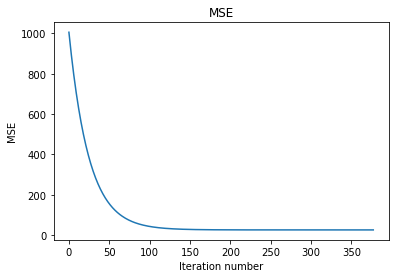

In [18]:
plt.plot(range(len(errors)), errors)
plt.title('MSE')
plt.xlabel('Iteration number')
plt.ylabel('MSE')

In [19]:
def sgd_gradient_descent(X, y, iterations, qty_in_batch, alpha):
    W = np.random.randn(X.shape[0])
    n = X.shape[1]
    n_batch = n // qty_in_batch

    if n % qty_in_batch != 0:
        n_batch += 1
    errs = []

    for i in range(1, iterations+1):
        for b in range(n_batch):
            start_ = qty_in_batch*b
            end_ = qty_in_batch*(b+1)
        
            X_tmp = X[:, start_ : end_]
            y_tmp = y[start_ : end_]
            y_pred_tmp = np.dot(W, X_tmp)
            W -= (alpha * (1/n * 2 * np.dot((y_pred_tmp - y_tmp), X_tmp.T)))
        errs.append(calc_mse(y_tmp, y_pred_tmp))

    y_pred = np.dot(W, X_stand)
    mse_ = (sum((y - y_pred)**2)) / len(y)

    return W, mse_, errs

In [20]:
W, mse_, errs = sgd_gradient_descent(X_stand, y, 1000, qty_in_batch=64, alpha=1e-2)
mse_

25.30701604772961

Text(0, 0.5, 'MSE')

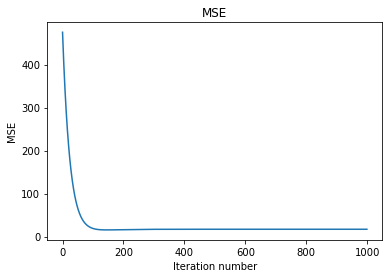

In [21]:
plt.plot(range(len(errs)), errs)
plt.title('MSE')
plt.xlabel('Iteration number')
plt.ylabel('MSE')

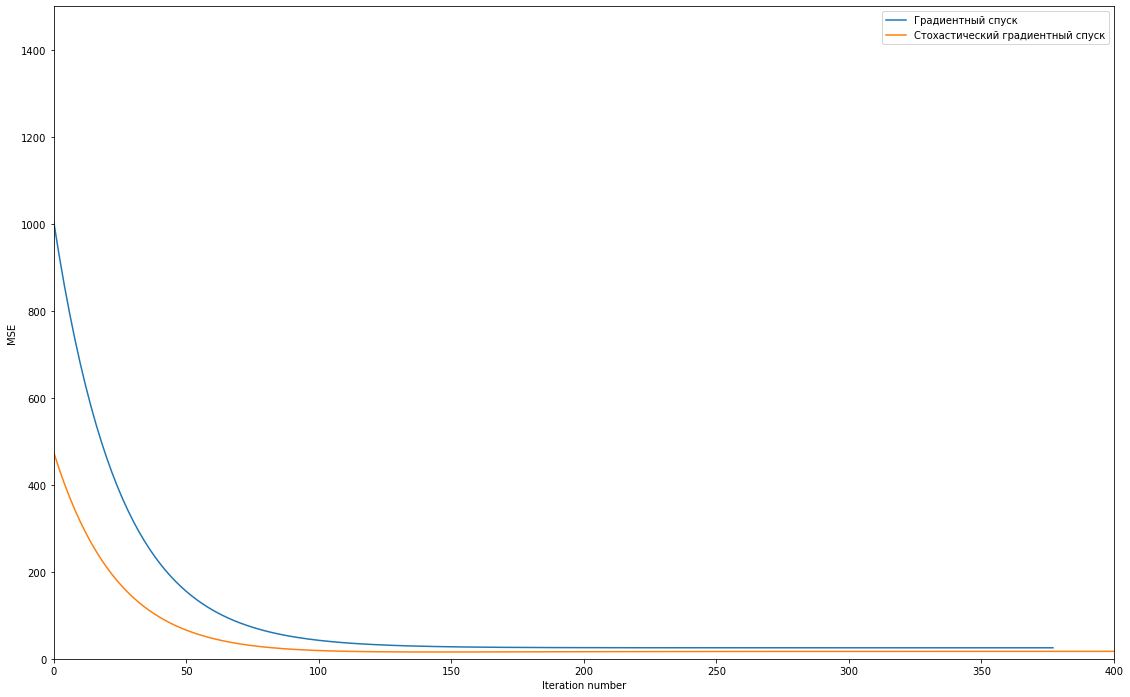

In [22]:
plt.figure(figsize=(19, 12))
plt.plot(range(len(errors)), errors, label="Градиентный спуск")
plt.plot(range(len(errs)), errs, label="Стохастический градиентный спуск")
plt.axis([0, 400, 0, 1500])
plt.xlabel('Iteration number')
plt.ylabel('MSE')
plt.legend()
plt.show()
# Стохастический г. с. сходится быстрее

In [23]:
def eval_model_reg2(X, y, iterations, alpha, lambda_):
    np.random.seed(15)
    W = np.random.randn(X.shape[0])
    n = X.shape[1]

    for i in range(1, iterations+1):
        y_pred = np.dot(W, X)
        err = calc_mse(y, y_pred)
        W -= alpha * (1/n * 2 * np.dot((y_pred - y), X.T) + lambda_ * W) 

    if i % (iterations / 10) == 0:
        print(i, W, err)

    return W

In [24]:
eval_model_reg2(X_stand, y, iterations=5000, alpha=1e-2, lambda_=1e-4)

5000 [-0.56613518 16.9711513  28.2168982 ] 25.307016826870147


array([-0.56613518, 16.9711513 , 28.2168982 ])

In [25]:
def gradient_descent_alpha_div_i_reg2(X, y, start_alpha, epsilon, lambda_):
    lambda_=1e-8
    n = X.shape[1]
    W = np.random.randn(X.shape[0])
    i=1
    W_prev = np.array([])
    err_prev = 0
    err = 0
    errors = []

    while True:
        W_prev = W.copy()
        err_prev = err
        y_pred = np.dot(W, X)
        err = calc_mse(y, y_pred)
        W -= start_alpha/i * (1/n * 2 * np.dot(X, (y_pred - y))+ lambda_ * W) 
        errors.append(err)

        if np.sum(np.abs(W - W_prev)) < epsilon:
            break
        i+=1


    return W_prev, err_prev

In [26]:
gradient_descent_alpha_div_i_reg2(X_stand, y, start_alpha=1, epsilon = 0.00001, lambda_=1e-5)

(array([-0.56616349, 16.97191461, 28.21826165]), 25.307014128719025)

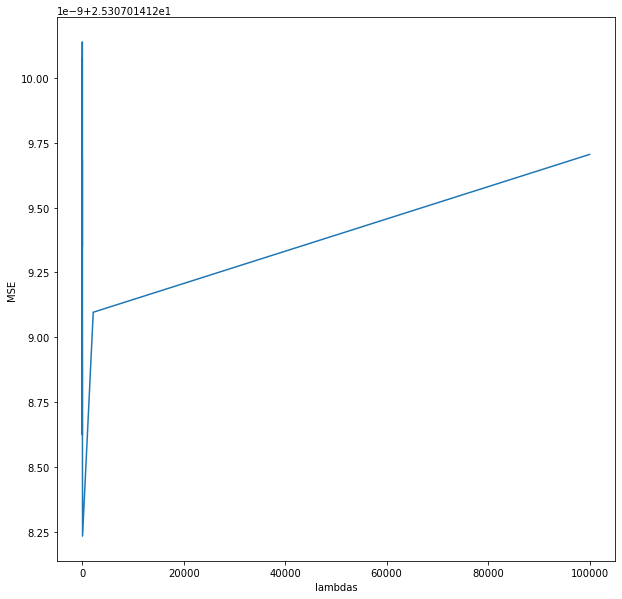

In [27]:
lambdas_list = np.logspace(-10, 5, 10)
errors = []

for i in lambdas_list:
    weight, error = gradient_descent_alpha_div_i_reg2(X_stand, y, start_alpha=1, epsilon = 0.00001, lambda_=1e-4)
    errors.append(error)


plt.figure(figsize=(10, 10))
plt.plot(lambdas_list, errors)
plt.xlabel('lambdas')
plt.ylabel('MSE')
plt.show()

In [28]:
# 3.

def gradient_descent_alpha_div_i_reg1(X, y, start_alpha, epsilon, lambda_):
    n = X.shape[1]
    W = np.random.randn(X.shape[0])
    i=1
    W_prev = np.array([])
    err_prev = 0
    err = 0
    errors = []

    while True:
        W_prev = W.copy()
        err_prev = err
        y_pred = np.dot(W, X)
        err = calc_mse(y, y_pred)
        W -= start_alpha/i * (1/n * 2 * np.dot(X, (y_pred - y))+ lambda_ * np.sign(W)) 
        errors.append(err)

        if np.sum(np.abs(W - W_prev)) < epsilon:
            break
        i+=1
   
    return W_prev, err_prev

In [29]:
gradient_descent_alpha_div_i_reg1(X_stand, y, start_alpha=1, epsilon = 0.00001, lambda_=1e-5)

(array([-0.56615849, 16.97190619, 28.21825102]), 25.30701413169353)

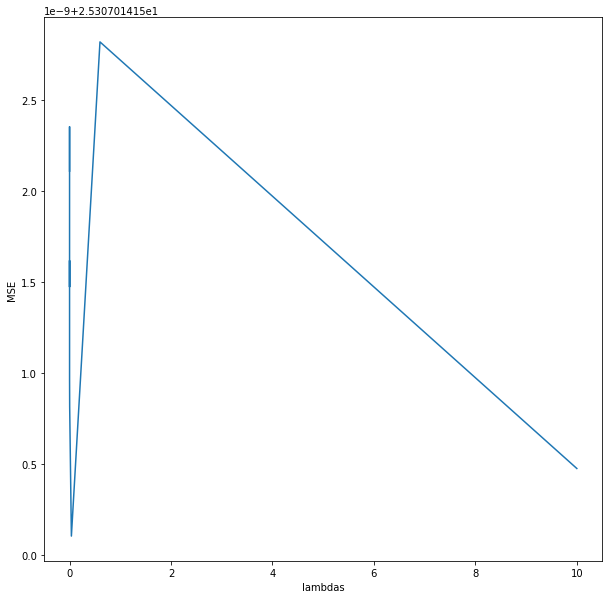

In [30]:
lambdas_list = np.logspace(-10, 1, 10)
errors = []
for i in lambdas_list:
    weight, error = gradient_descent_alpha_div_i_reg1(X_stand, y, start_alpha=1, epsilon = 0.00001, lambda_=1e-4)
    errors.append(error)


plt.figure(figsize=(10, 10))
plt.plot(lambdas_list, errors)
plt.xlabel('lambdas')
plt.ylabel('MSE')
plt.show()